In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
sys.path.append("/home/camp/warnert")
sys.path.append("/home/camp/warnert/working/Recordings/binary_pulses/blip_manuscript")
import blip_analysis_manu as ba
import exp_blip_models_manu as em
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe

Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1408 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4608 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4288 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1440 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file

In [2]:
glyphs = []
for i in ba.get_trial_array():
    glyph_str = ''
    for j in i:
        if j == 1:
            glyph_str+='\u25AE'
        else:
            glyph_str += '\u25AF'



    glyphs.append(glyph_str)
    print(glyph_str)

▯▯▯▯▯
▯▯▯▯▮
▯▯▯▮▯
▯▯▯▮▮
▯▯▮▯▯
▯▯▮▯▮
▯▯▮▮▯
▯▯▮▮▮
▯▮▯▯▯
▯▮▯▯▮
▯▮▯▮▯
▯▮▯▮▮
▯▮▮▯▯
▯▮▮▯▮
▯▮▮▮▯
▯▮▮▮▮
▮▯▯▯▯
▮▯▯▯▮
▮▯▯▮▯
▮▯▯▮▮
▮▯▮▯▯
▮▯▮▯▮
▮▯▮▮▯
▮▯▮▮▮
▮▮▯▯▯
▮▮▯▯▮
▮▮▯▮▯
▮▮▯▮▮
▮▮▮▯▯
▮▮▮▯▮
▮▮▮▮▯
▮▮▮▮▮


In [3]:
ba.units_usrts[1] = None
units_usrt1 = ba.get_usrts(1, pre_trial_window=0.5)
# units_usrt2 = ba.get_usrts(3)
# units_usrt3 = ba.get_usrts(5)

/home/camp/warnert/neurolytics/joined_recording.py:79: UserWarning: Mismatch in repeat lengths, cannot make full numpy array
  warnings.warn('Mismatch in repeat lengths, cannot make full numpy array')


(11, 212)


In [21]:
def split_bs_data(usrt, test_size=1, bs_size=60):
    train = []
    test = []
    for unit in usrt:
        unit_train = []
        unit_test = []
        for stimuli in unit:
            test_repeat_index = np.random.choice(np.arange(len(stimuli)), size=1)
            rest_index = np.arange(len(stimuli))
            rest_index = np.delete(rest_index, test_repeat_index)
            bs_indexes = np.random.choice(rest_index, size=bs_size, replace=True)
            bs_data = stimuli[bs_indexes]
            unit_train.append(bs_data)
            unit_test.append(stimuli[test_repeat_index])
        train.append(unit_train)
        test.append(unit_test)
    train = np.array(train)
    test = np.array(test)
    return train, test

In [242]:
train, test = split_bs_data(units_usrt1)

In [21]:
print(train.sum(axis=-1).shape)
print(test.sum(axis=-1)[:, :, 0].shape)
y_train = [i for i in range(32) for j in range(60)]


(145, 32, 60)
(145, 32)


In [24]:
train, test = split_bs_data(units_usrt1)
train = train.sum(axis=-1).reshape(145, -1)
test = test.sum(axis=-1).reshape(145, -1)
y_train = [i for i in range(32) for j in range(60)]
y_test = list(range(32))
svm = LinearSVC(C=1000, max_iter=100000)
svm.fit(train.T, y_train)
svm.predict(test.T)

array([ 1,  3,  3,  3,  7,  5,  5, 10, 18, 10, 11, 21, 13, 17, 11, 15, 24,
       17, 20, 20, 16, 14, 20, 13, 26, 12, 25, 23, 27, 28, 27, 29])

In [240]:
def svm_fit(usrt, bs_size=60):
    train, test= split_bs_data(usrt)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [320]:
joined_usrt = np.concatenate([units_usrt1, units_usrt2, units_usrt3], axis=1)
print(joined_usrt.shape)

(145, 96)


In [365]:
train, test = split_bs_data(units_usrt1)
onset = 10
window_size = 50
train[:, :, :, onset:onset+window_size]
test.shape

(145, 32, 1, 212)

In [321]:
def svm_fit_all(usrts, bs_size=60):
    train, test= split_bs_data(usrts)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(96) for j in range(bs_size)]
    y_test = list(range(96))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [369]:
def svm_fit_window(usrt, onset, window_size, bs_size=60):
    train, test= split_bs_data(usrt)
    train =train[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    test =test[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test, onset

In [370]:
pred, y_test, onset = svm_fit_window(units_usrt1, 10, 50)

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [373]:
print(onset)

10


In [26]:
pred, y_test = svm_fit(units_usrt1)

In [7]:
dasked = daskify.Daskified()

In [8]:
dasked.start_cluster()

In [9]:
client = dasked.client

In [419]:
scatterd_usrt1 = client.scatter(units_usrt1)
# scatterd_usrt2 = client.scatter(units_usrt2)
# scatterd_usrt3 = client.scatter(units_usrt3)

In [322]:
scattered_joined = client.scatter(joined_usrt)

In [244]:
futures = [dask.delayed(svm_fit)(scatterd_usrt1) for i in range(500)]

In [323]:
futures = [dask.delayed(svm_fit_all)(scattered_joined) for i in range(500)]

In [425]:
futures = [[dask.delayed(svm_fit_window)(scatterd_usrt1, j, 50) for i in range(100)] for j in range(212-50)]
futures = list(np.concatenate(futures))

In [410]:
print(futures[0])

Delayed('svm_fit_window-04192990-9ba1-428b-9ee5-d852642575aa')


In [415]:
client.close()

In [428]:
dask_outs = client.compute(futures)

In [407]:
print(len(dask_outs))

81000


In [412]:
print(dask_outs[0][0][0].status)

Delayed('getattr-e36c12da7d6a5f8f56d1d0e49b39ac97')


In [422]:
print(dask_outs[0].status)

Delayed('getattr-668ee730701f863bef8cebec7c52cdad')


In [561]:
status = np.array([i.status for i in dask_outs])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))

['finished']
finished 16200


In [562]:
reses_window = [i.result() for i in tqdm(dask_outs, position=0, leave=False)]

100%|█████████▉| 16145/16200 [00:28<00:00, 588.26it/s]


In [563]:
onsets = [i[-1] for i in reses_window]
reses_window = [[i[0], i[1]] for i in reses_window]

In [574]:
reses_window = np.array(reses_window)
onsets = np.array(onsets)
preds_window = reses_window[:, 0].reshape(162, 100, 32)
trues_window = reses_window[:, 1].reshape(162, 100, 32)
print(preds_window.shape)
print(preds_window.reshape(162, 100, 32).shape)
onsets_reshape = onsets.reshape(162, 100)


(162, 100, 32)
(162, 100, 32)


In [577]:
print(trues_window[0].shape)

(100, 32)


In [578]:
cms_window = np.array([confusion_matrix(np.concatenate(trues_window[i]), np.concatenate(preds_window[i]), labels=list(range(32)), normalize='true') for i in range(162)])

In [590]:
print(np.max(cms_window))

0.74


In [596]:
avg_accs = [np.mean([i[j, j] for j in range(32)]) for i in cms_window]

In [620]:
np.save('221017_preds_window.npy', preds_window)
np.save('221017_trues_window.npy', trues_window)

In [619]:


times = np.arange(-1, 0.62, 1/100)
for index, i in enumerate(times):
    fig,ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
    im = ax[1].imshow(cms_window[index], cmap='pink')#, vmax=0.74)
    fig.suptitle(f'Onset: {i:0.2}s')
    ax[1].set_xticks(range(32))
    ax[1].set_xticklabels(glyphs, rotation=90, fontsize=9)
    ax[1].set_yticks(range(32))
    ax[1].set_yticklabels(glyphs, fontsize=9)
    plt.colorbar(ax = ax[1], mappable=im)
    ax[1].set_ylim(31.5, -.5)
    
    ax[0].plot(times, avg_accs, color='k')
    ax[0].scatter(i, avg_accs[index], color='r', zorder=10)
    ax[0].axvspan(-.5, 0, color='lightgray')
    ax[0].set_xlabel('Onset (s)')
    ax[0].set_ylabel('Average accuracy')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    plt.savefig(f'Avg_accuracy_cm_no_vmax//{index}.png')
    plt.close()

In [ ]:
reses = [i.result() for i in tqdm(dask_outs)]

In [345]:
reses = np.array(reses)
print(reses.shape)

(500, 2, 96)


In [346]:
preds = reses[:, 0]
trues = reses[:, 1]

In [347]:
cm = confusion_matrix(np.concatenate(trues), np.concatenate(preds), labels=list(range(96)), normalize='true')

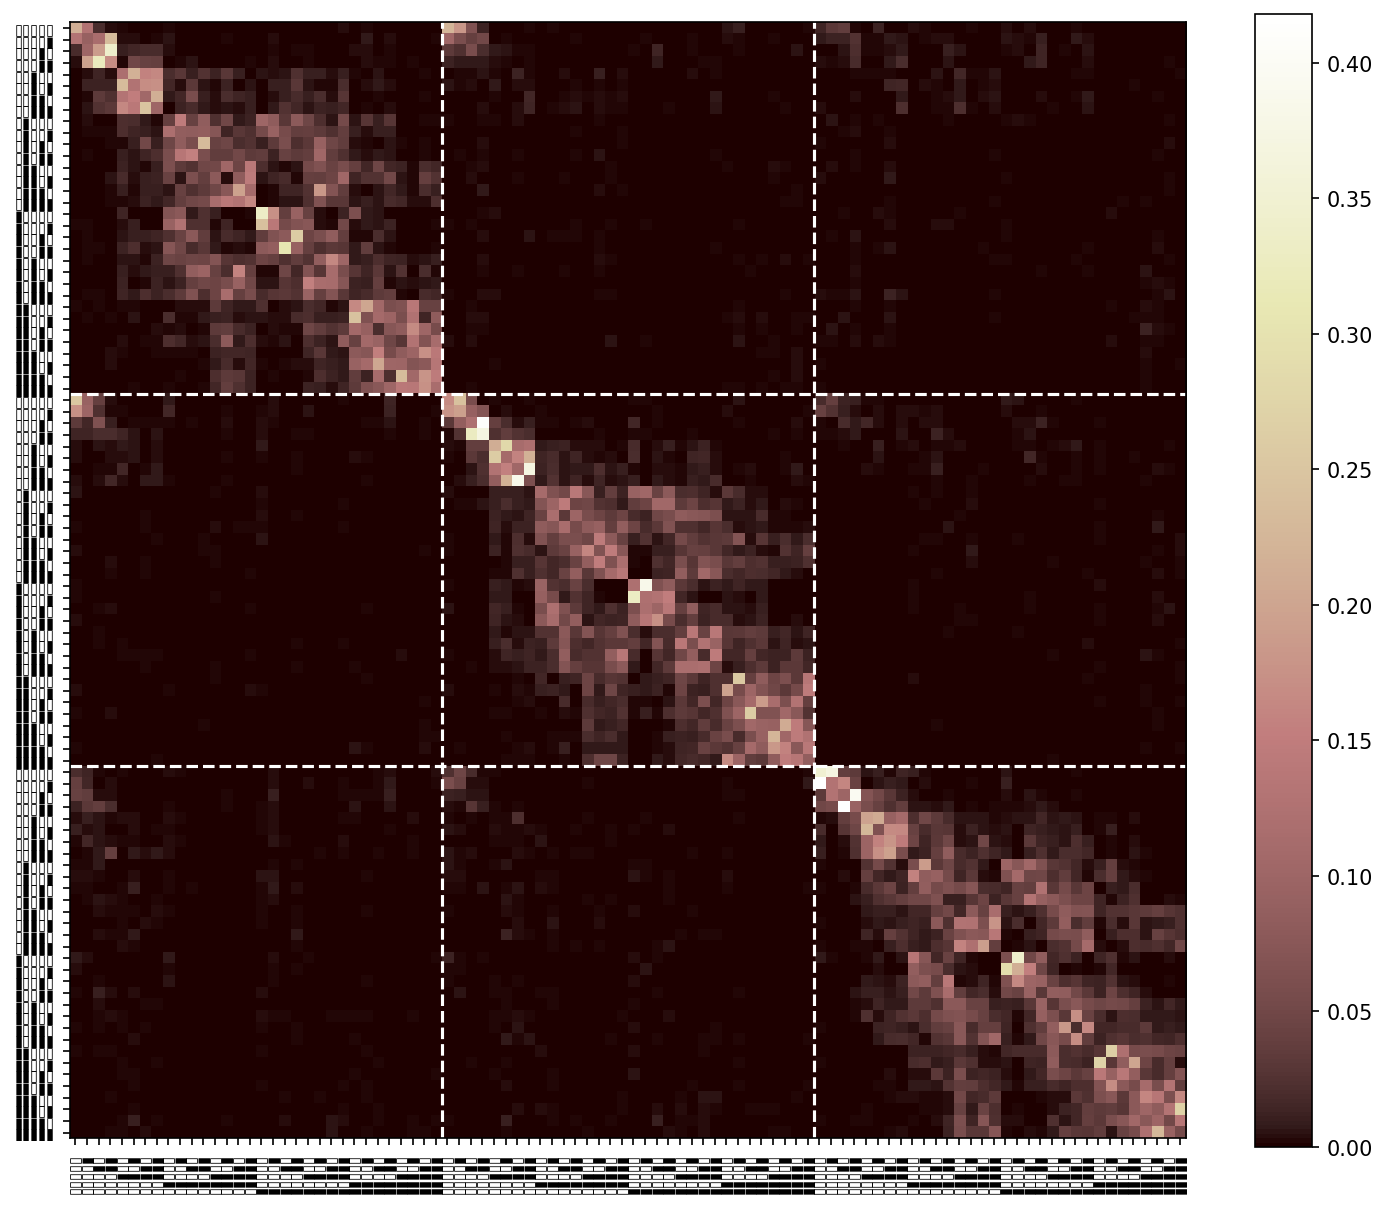

In [358]:
plt.figure(figsize=(12, 10), dpi=150)
plt.imshow(cm, cmap='pink')
plt.xticks(range(96), labels=glyphs*3, rotation=90, fontsize=7);
plt.yticks(range(96), labels=glyphs*3, fontsize=7);
plt.ylim(95.5, -.5)
plt.colorbar()
plt.axhline(31.5, linestyle='--', color='white')
plt.axhline(63.5, linestyle='--', color='white')

plt.axvline(31.5, linestyle='--', color='white')
plt.axvline(63.5, linestyle='--', color='white')

(1.5, -0.5)

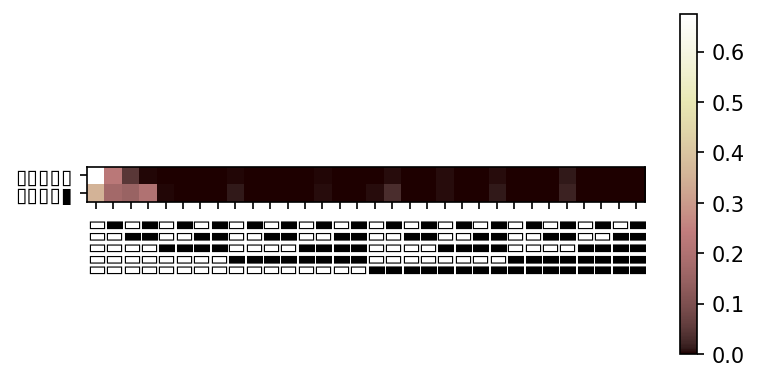

In [315]:
plt.figure(figsize=(6, 3), dpi=150)
plt.imshow(cm[:2], cmap='pink')
plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=10);
plt.yticks(range(2), labels=glyphs[:2], fontsize=10);
plt.colorbar()
plt.ylim(1.5, -.5)


/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


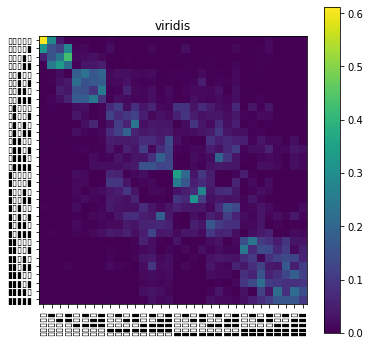

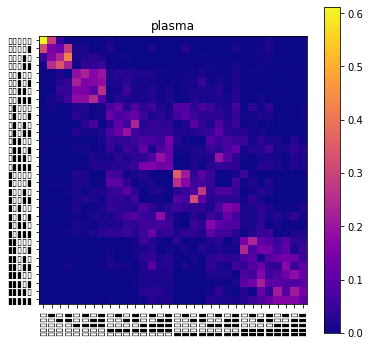

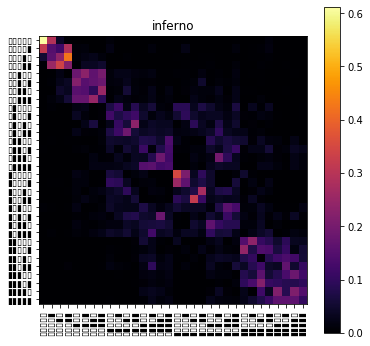

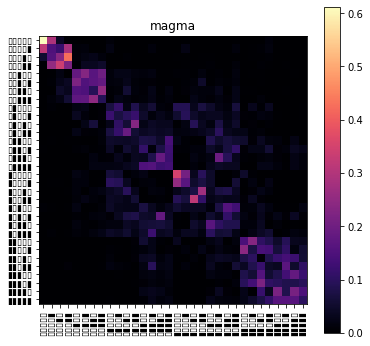

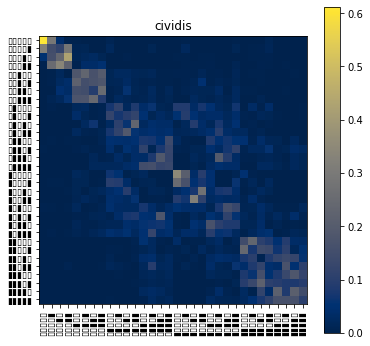

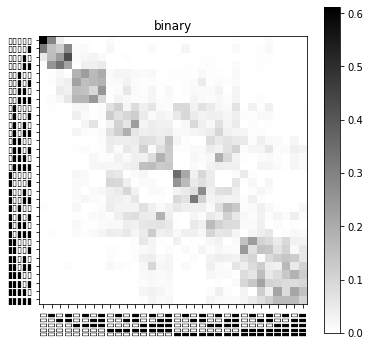

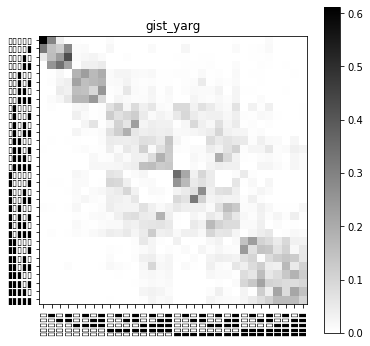

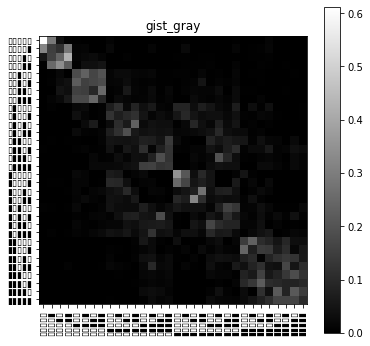

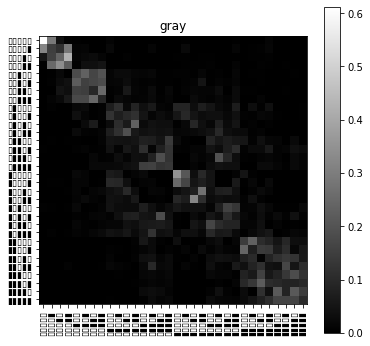

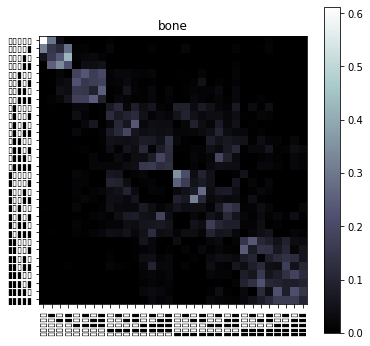

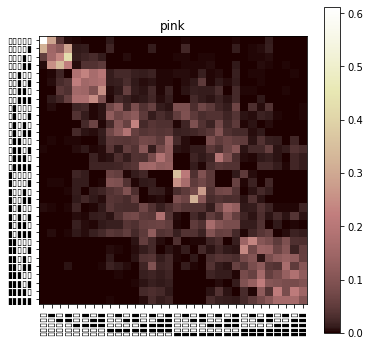

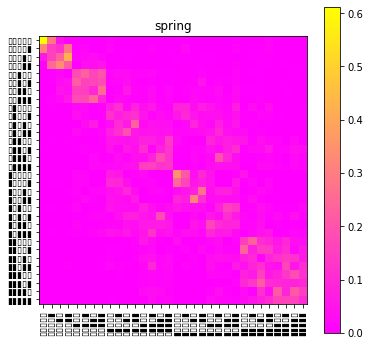

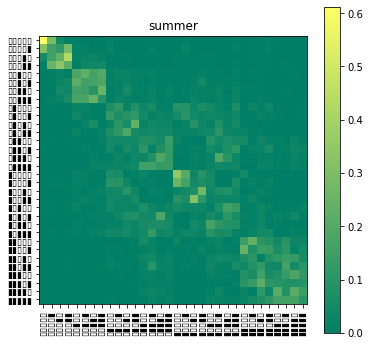

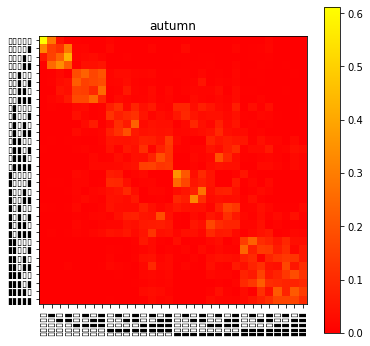

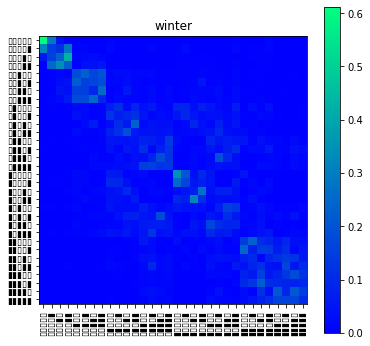

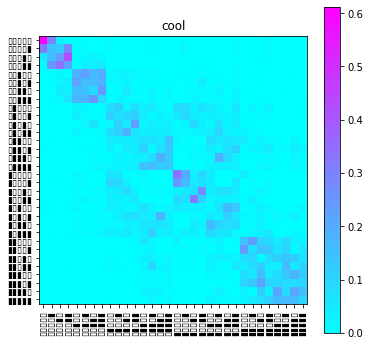

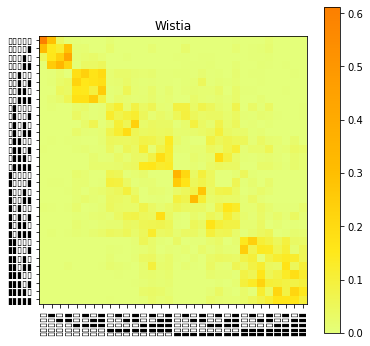

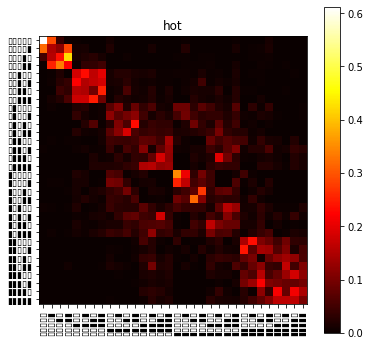

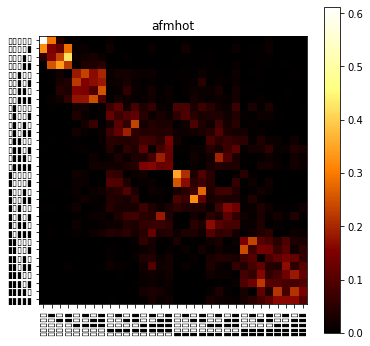

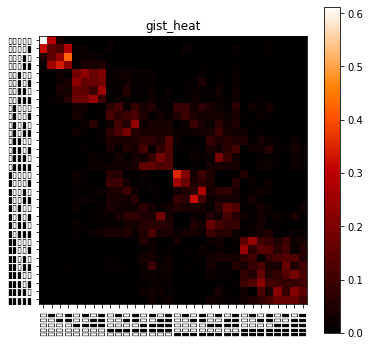

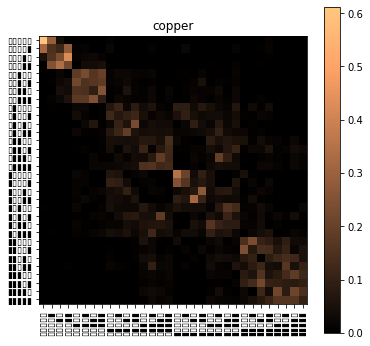

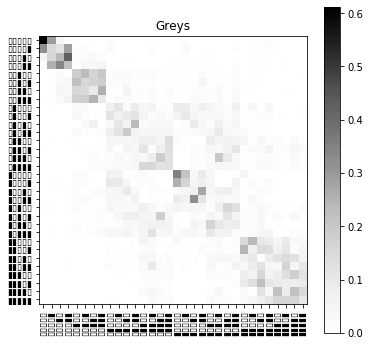

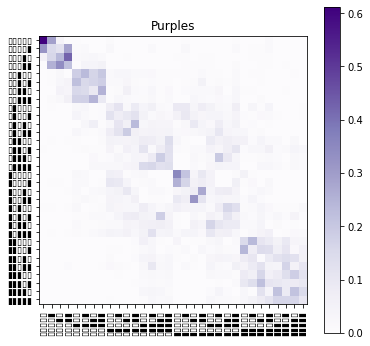

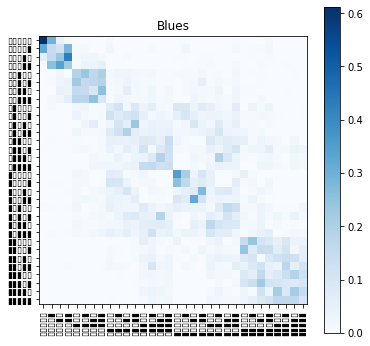

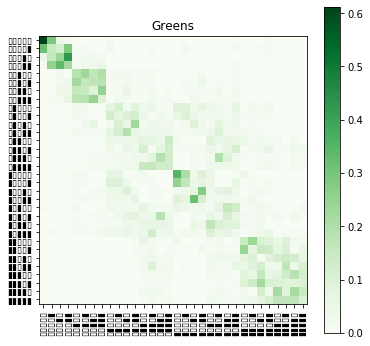

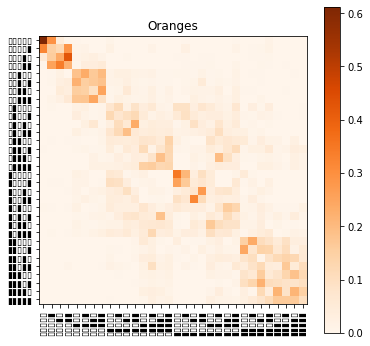

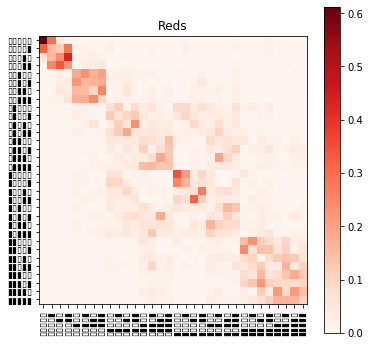

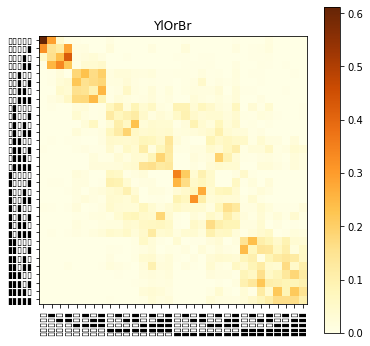

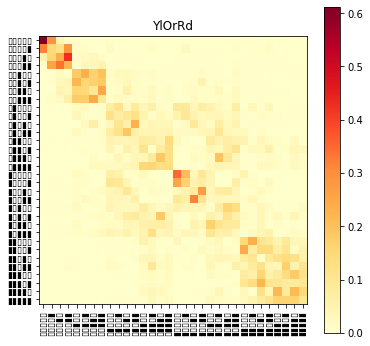

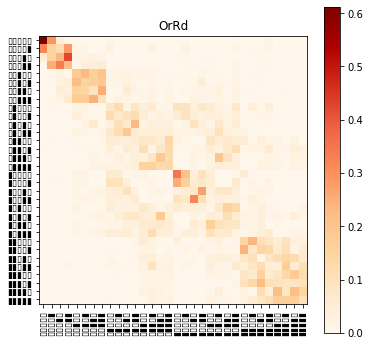

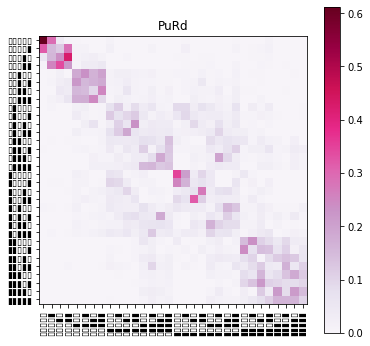

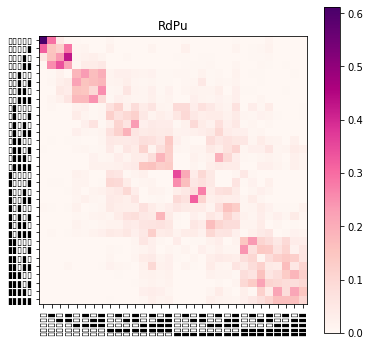

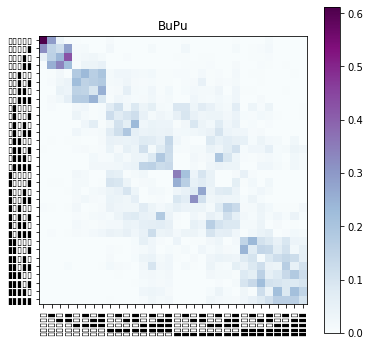

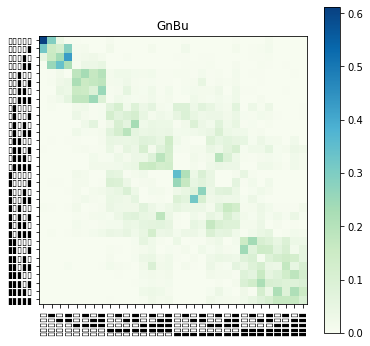

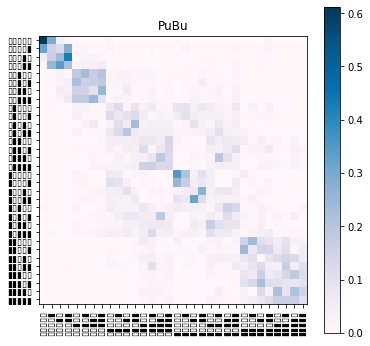

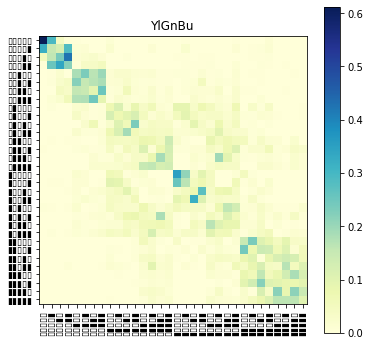

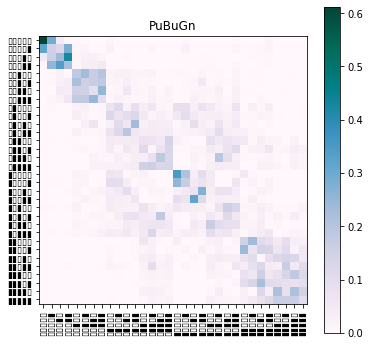

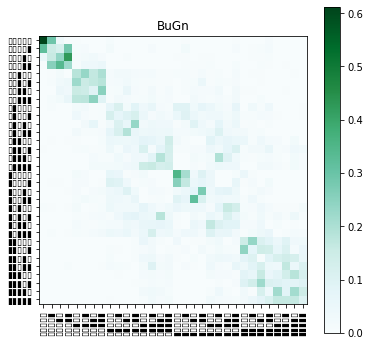

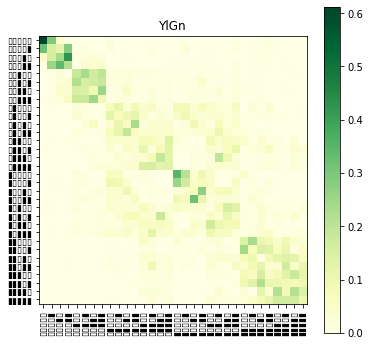

In [22]:
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(len(cmaps)):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=cmaps[i], vmin=0)
    plt.title(cmaps[i])
    plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=9)
    plt.yticks(range(32), labels=glyphs, fontsize=9)
    plt.ylim(31.5, -.5)
    plt.colorbar()

In [11]:
mean_usrt = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])

print(mean_usrt.shape)

(145, 32, 100)


In [25]:
mean_usrt1_scattered = client.scatter(mean_usrt)

In [12]:
dms = [distance_matrix(mean_usrt[:, :, i].T, mean_usrt[:, :, i].T) for i in range(100)]


In [505]:
rec = ba.recs.recordings[-2]

In [506]:
rec_channel = oe.loadContinuous2(rec.home_dir + '/'+rec.resp_channel)['data']

Text(0.5, 0, 'Time (ms)')

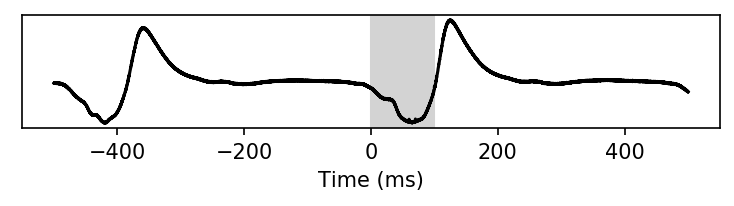

In [518]:
trial_start = rec.trial_starts[1500]
xs=  np.arange(-500, 500, 1/30)
plt.figure(figsize=(6, 1), dpi=150)
plt.plot(xs, rec_channel[trial_start-15000:trial_start+15000], color='k')
plt.yticks([])
plt.axvspan(0, 100, color='lightgray')
plt.xlabel('Time (ms)')

In [9]:
def time_minimisation(coords, true_distances):
    coords = coords.reshape(32, 50)
    

In [173]:
def dask_de(dm, tol=0.0001):
    bounds = [[-1000, 1000]]*32
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dm])
    return de

In [174]:
de_futures = [dask.delayed(dask_de)(dms[i]) for i in range(50)]

In [175]:
de_outs = client.compute(de_futures)

In [176]:
dasked.current_futures = de_outs

In [198]:
dasked.check_progress()

finished 50


In [199]:
de_res = [i.result() for i in de_outs]

In [202]:
print(len())

50


In [203]:
distances = np.array([i.x for i in de_res])

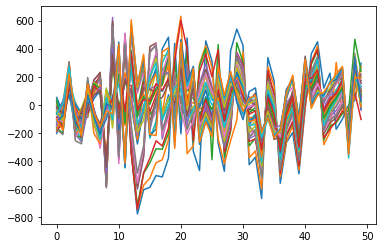

In [205]:
for i in range(32):
    plt.plot(distances[:, i])

In [119]:
bounds = [[-1000, 1000]]*32
print(bounds)
des = []
for i in tqdm(range(50)):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms[i]], init='sobol')
    des.append(de)


  0%|          | 0/50 [00:00<?, ?it/s]

[[-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000]]



100%|██████████| 50/50 [05:19<00:00,  6.38s/it]


In [100]:
print(mean_usrt.shape)

(145, 32, 50)


In [107]:
normed_usrt1 = mean_usrt - np.mean(mean_usrt, axis=1)[:, np.newaxis]

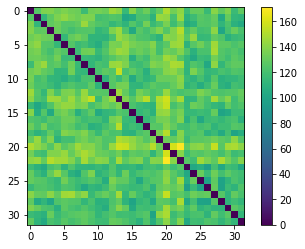

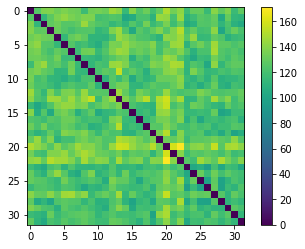

In [114]:
dm_test = distance_matrix(normed_usrt1[:, :, 0].T, normed_usrt1[:, :, 0].T)
plt.imshow(dm_test)
plt.colorbar()
plt.figure()
plt.imshow(dms[0])
plt.colorbar()

In [66]:
out = mds.fit_transform(mean_usrt.reshape(145, -1).T)
print(out.shape)

(1600, 1)


In [115]:
print(mean_usrt.shape)

normed_usrt = mean_usrt - np.mean(mean_usrt, axis=1)[:, np.newaxis]


(145, 32, 50)


In [116]:
out = mds.fit_transform(normed_usrt.reshape(145, -1).T)
print(out.shape)

(1600, 1)


In [117]:
out_reshaped = out.T.reshape(32, 50)

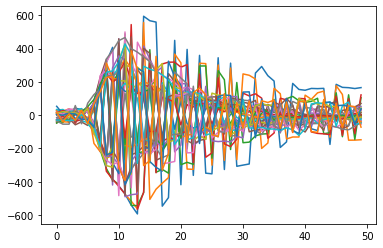

In [118]:
for i in out_reshaped:
    plt.plot(i)

In [64]:
mean_usrt[:, :, i].T.shape

(32, 145)

In [144]:
mds = MDS(n_components=1)
out = mds.fit_transform(mean_usrt.reshape(145, -1).T)

In [148]:
out_reshaped = out.T.reshape(32, 50)

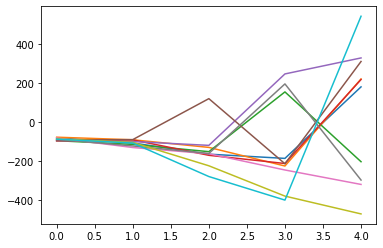

In [155]:
plt.plot(out_reshaped.T[5:10, :10]);

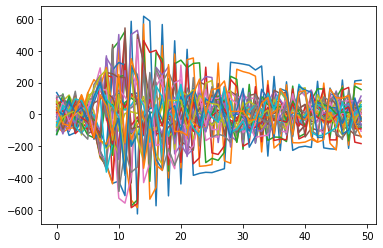

In [63]:
plt.plot(np.array(des));

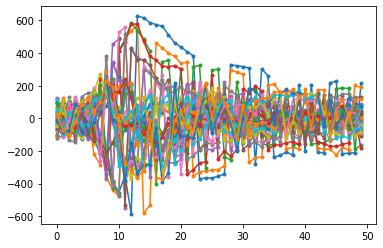

In [132]:
plt.plot(np.array(des), '.-');

In [22]:
distances = [i.x for i in des]
#distances = [i.x for i in de_res]
print(np.array(distances).shape)

(50, 32)


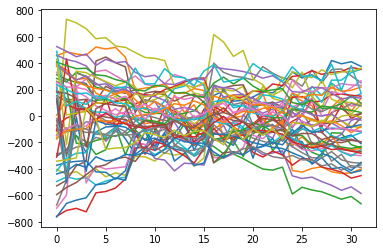

In [23]:
for i in distances:
    plt.plot(i)

In [12]:
distances = np.array(distances)
distances = distances - np.mean(distances, axis=1)[:, np.newaxis]
print(distances.shape)

NameError: name 'distances' is not defined

In [37]:
distances_flipped = [distances[0], distances[1]]
for i in range(2, 50):
    prev_distance = distances_flipped[i-1]
    distance = distances[i]
    #print(distance)
    #rint(prev_distance)
#     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
#     print('a')
    if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
        distances_flipped.append(distance)
    else:
        distances_flipped.append(-distance)

In [6]:
def de_minimisation(coords, true_distances):
    coords = coords[:, np.newaxis]
    #print(coords)

    dm = distance_matrix(coords, coords)
#     dm_off = np.triu(dm, 1)

    loss = np.sum(np.abs(true_distances.ravel() - dm.ravel()))
    return loss

def de_minimisation_across(coords, true_distances, prev_coords, alpha):
    coords = coords[:, np.newaxis]
    
    dm = distance_matrix(coords, coords)
    coords_normed = coords - coords.mean()
    if np.sum((coords - prev_coords)**2) > np.sum((coords + prev_coords)**2):
        coords_diff = np.sum((coords + prev_coords)**2)
    else:
        coords_diff = np.sum((coords - prev_coords)**2)
    loss = np.sum((true_distances.ravel() - dm.ravel())**2) + alpha*coords_diff #+ np.mean(coords)
    return loss

def dask_de_minimisation(true_distances):
    bounds = [[0, 1000]]*32
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[true_distances], popsize=50, tol=0.001, maxiter=10000, )
    coords = de.x
    coords = coords - coords.mean()
    return coords

In [181]:
dask_de_minimisation(dms[0])

array([ -96.4019998 ,   73.28107749,  -82.86560244,   59.28977963,
         74.90438148,  -69.04974583,  -87.80833471,  -59.80580091,
        -66.22125212,   47.0986759 ,  -28.91430293,  -35.86636369,
         90.61001114, -108.89093924,   99.1544074 ,   48.26600283,
         30.76177485,   82.44465468,   14.57069218, -122.31389069,
       -138.230831  ,  106.08270972,  130.3967947 ,   -5.46446457,
        -43.82262232,  -19.19651886,  -40.54121341,  111.55515068,
        -14.43152103,   40.43316   ,   19.905228  ,   -8.92909713])

In [13]:
futures = np.concatenate([[dask.delayed(dask_de_minimisation)(i) for i in dms] for j in range(50)])
outs = client.compute(list(futures))
dasked.current_futures = outs

In [79]:
dasked.check_progress()

finished 5000


In [80]:
res = [i.result() for i in tqdm(outs)]

100%|██████████| 5000/5000 [00:09<00:00, 547.62it/s]


In [81]:
res = np.array(res).reshape(50, 100, 32)


In [82]:
np.save('221025_de_1d_res.npy', res)

In [4]:
res = np.load('221025_de_1d_res.npy')

In [5]:
print(res.shape)

(50, 100, 32)


In [7]:
flipped_distances = np.array([flip_distances(i) for i in res])

In [231]:
print(flipped_distances.shape)

(10, 50, 32)


In [8]:
flipped_flipped_distances = [flipped_distances[0]]
for i in range(1, 50):
    if np.sum(np.abs(flipped_distances[0]+flipped_distances[i])) > np.sum(np.abs(flipped_distances[0]-flipped_distances[i])):
        flipped_flipped_distances.append(flipped_distances[i])
    else:
        flipped_flipped_distances.append(-flipped_distances[i])

Text(0.5, 0, 'Time (s)')

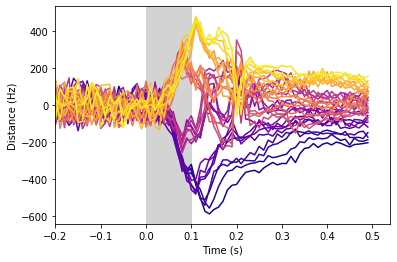

In [18]:
med_flipped = np.median(flipped_flipped_distances, axis=0)
xs = np.arange(-.5, .5, 1/100)
for i in range(32):
    plt.plot(xs, med_flipped[:, i], color=matplotlib.cm.plasma(i/32))
plt.axvspan(0, .1, color='lightgray')
plt.xlim(-0.2,)
plt.ylabel('Distance (Hz)')
plt.xlabel('Time (s)')


Text(0.5, 0, 'Time (s)')

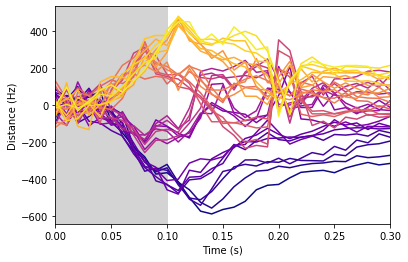

In [20]:
med_flipped = np.median(flipped_flipped_distances, axis=0)
xs = np.arange(-.5, .5, 1/100)
for i in range(32):
    plt.plot(xs, med_flipped[:, i], color=matplotlib.cm.plasma(i/32))
plt.axvspan(0, .1, color='lightgray')
plt.xlim(0,0.3)
plt.ylabel('Distance (Hz)')
plt.xlabel('Time (s)')


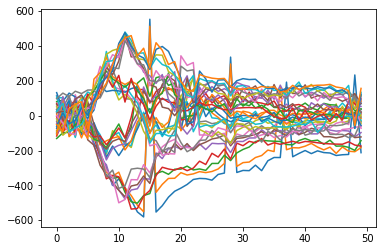

In [230]:
for i in range(32):
    plt.plot(flipped_distances[8, :, i])

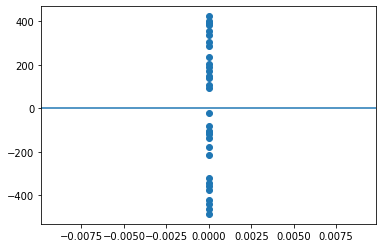

In [184]:
a =dask_de_minimisation(dms[10])


In [120]:
ws = 10
dms_roll = [distance_matrix(np.mean(mean_usrt[:, :, i:i+ws], axis=-1).T, np.mean(mean_usrt[:, :, i:i+ws], axis=-1).T) for i in range(50-ws)]

In [121]:


bounds = [[-1000, 1000]]*32
print(bounds)
des = []
for i in tqdm(range(50-ws)):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms_roll[i]])
    des.append(de)
distances = np.array([i.x for i in des])



  0%|          | 0/40 [00:00<?, ?it/s]

[[-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000]]



100%|██████████| 40/40 [04:39<00:00,  6.99s/it]


In [122]:
distances = np.array([i.x for i in des])

In [123]:
distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
distances_flipped = [distances_normed[0]]
for i in range(1, 50-ws):
    prev_distance = distances_flipped[i-1]
    distance = distances_normed[i]
    #print(distance)
    #rint(prev_distance)
#     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
#     print('a')
    if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
        distances_flipped.append(distance)
    else:
        distances_flipped.append(-distance)

In [6]:
def flip_distances(distances):
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, len(distances)):
        prev_distance = distances_flipped[-1]
        distance = distances_normed[i]
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    return distances_flipped

Text(0, 0.5, 'Euclidean distance (Hz)')

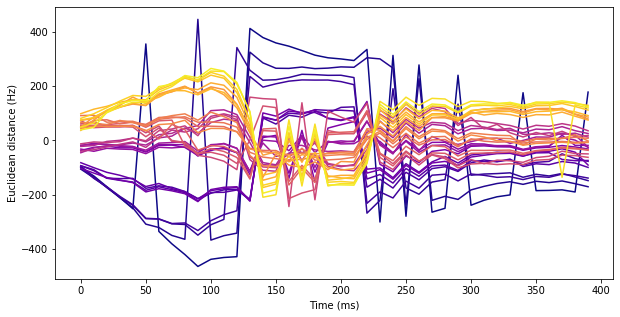

In [124]:
plt.figure(figsize=(10, 5))
xs = np.arange(0, 500-10*ws, 10)
for index, i in enumerate(np.array(distances_flipped).T):
    plt.plot(xs, i-np.mean(distances_flipped, axis=1), color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

Text(0, 0.5, 'Euclidean distance (Hz)')

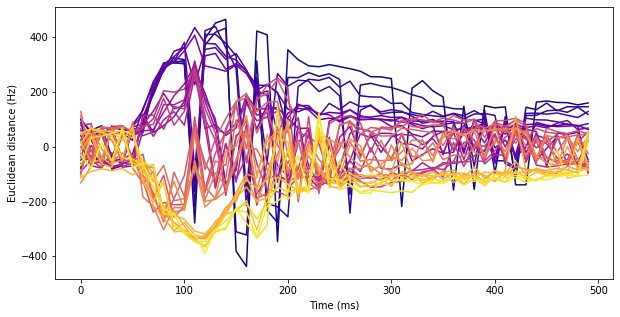

In [117]:
plt.figure(figsize=(10, 5))
xs = np.arange(0, 500, 10)
for index, i in enumerate(np.array(distances_flipped).T):
    plt.plot(xs, i-np.mean(distances_flipped, axis=1), color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

In [134]:
alpha = 2
bounds = [[0, 1000]]*32
print(bounds)
reps = 5
all_distances = []
for j in range(reps):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms[0]])
    distances = [de.x]
    for i in tqdm(range(1, 20)):
    #     print(distances[-1])
        de = scipy.optimize.differential_evolution(de_minimisation_across, bounds=bounds, args=[dms[i], distances[-1], alpha], init='sobol')
        distances.append(de.x)
#     distances = np.array(distances)
    all_distances.append(distances)

[[0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000], [0, 1000]]



100%|██████████| 19/19 [01:34<00:00,  4.99s/it]

100%|██████████| 19/19 [01:32<00:00,  4.86s/it]

100%|██████████| 19/19 [01:24<00:00,  4.43s/it]

100%|██████████| 19/19 [01:30<00:00,  4.75s/it]

100%|██████████| 19/19 [01:24<00:00,  4.43s/it]


In [135]:
all_distances_flipped = []
for distances in all_distances:
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, 20):
        prev_distance = distances_flipped[i-1]
        distance = distances_normed[i]
        #print(distance)
        #rint(prev_distance)
    #     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
    #     print('a')
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    all_distances_flipped.append(distances_flipped)

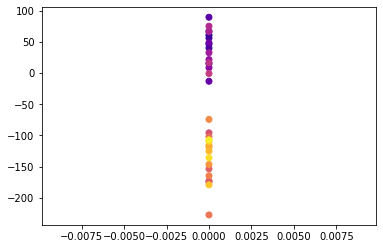

In [82]:
plt.scatter(np.zeros(32), distances[6], c=[matplotlib.cm.plasma(i/32) for i in range(32)])

In [107]:
print(np.sum(np.abs(distances[6] - distances[7])))

4953.200285128394


In [139]:
print(np.array(all_distances_flipped).shape)

(5, 20, 32)


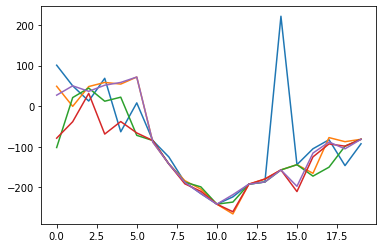

In [171]:
flips = [1, -1, 1, -1, 1]

for i in range(5):
    plt.plot(np.array(all_distances_flipped)[i, :, 5]*flips[i])

Text(0, 0.5, 'Euclidean distance (Hz)')

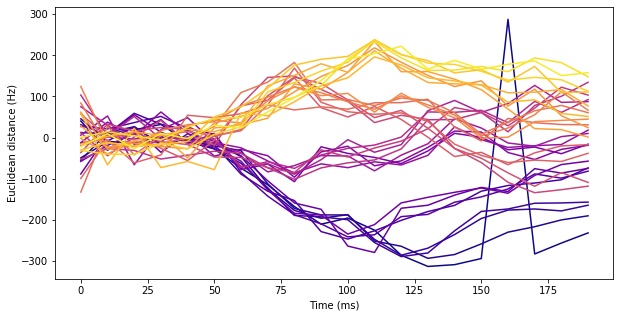

In [175]:
plt.figure(figsize=(10, 5))

xs = np.arange(0, 200, 10)
for index, i in enumerate(np.median(np.array(all_distances_flipped)*np.array(flips)[:, np.newaxis, np.newaxis], axis=0).T):
    plt.plot(xs, i,color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

Text(0, 0.5, 'Euclidean distance (Hz)')

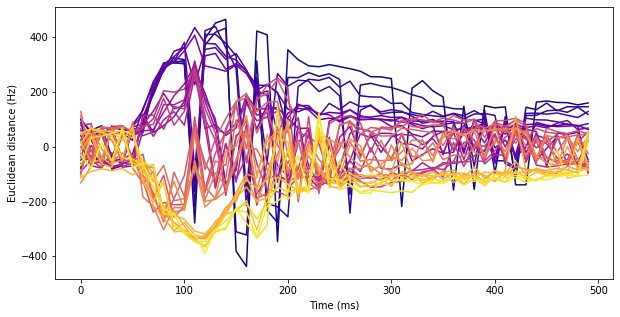

In [62]:
plt.figure(figsize=(10, 5))
xs = np.arange(0, 500, 10)
for index, i in enumerate(np.array(distances_flipped).T):
    plt.plot(xs, i, color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

Text(0, 0.5, 'Euclidean distance (Hz)')

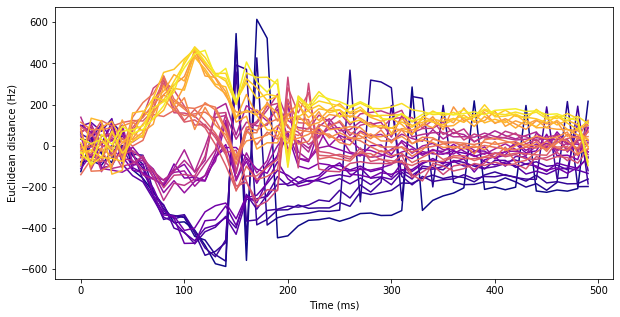

In [44]:
plt.figure(figsize=(10, 5))
xs = np.arange(0, 500, 10)
for index, i in enumerate(np.array(distances_flipped).T):
    plt.plot(xs, i, color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

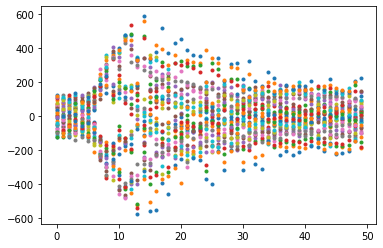

In [54]:
plt.plot(distances-np.mean(distances, axis=1)[:, np.newaxis], '.');

In [80]:
dm = distance_matrix(de.x.reshape(32, 2), de.x.reshape(32, 2))

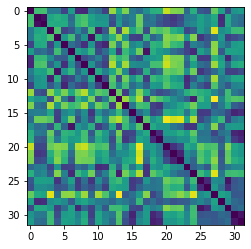

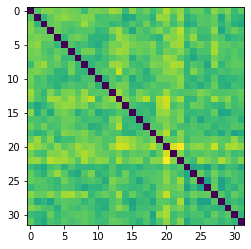

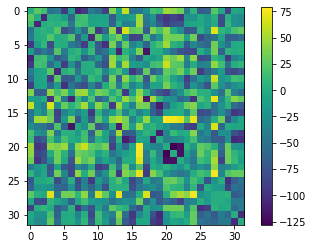

In [84]:
plt.imshow(dm)
plt.figure()
plt.imshow(dms[0])
plt.figure()
plt.imshow(dm-dms[0])
plt.colorbar()

In [51]:
lle = LocallyLinearEmbedding(n_neighbors=146)
lle_fit = lle.fit_transform(mean_usrt.T)

In [52]:
lle_fit = lle_fit.T.reshape(2, 32, 50)

In [53]:
print(lle_fit.shape)

(2, 32, 50)


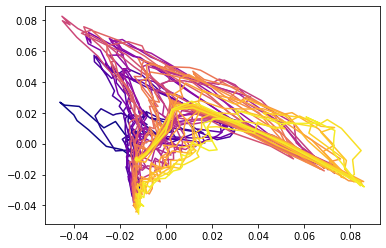

In [56]:
for i in range(32):
    plt.plot(lle_fit[0, i], lle_fit[1, i], color=matplotlib.cm.plasma(i/32))


In [58]:
print(mean_usrt.shape)

(145, 1600)
